In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pystan
import warnings
warnings.filterwarnings("ignore")

## Load data

In [68]:
df = pd.read_csv('data/president_general_polls_2016.csv')

## data cleaning

In [94]:
polls = df[['pollster', 'grade', 'state', 'createddate', 'samplesize', 'adjpoll_trump', 'adjpoll_clinton']]

nb_voters = [3606103, 519501, 4738332, 2148441, 25278803, 3978892, 2572337, 693659, 516771, 14601373, 6958725, 
             1029072, 1161211, 8983758, 4860929, 2297129, 2065761, 3276707, 3391431, 1058306, 4202282, 4978165, 
             7431589, 3972330, 2177349, 4519978, 803833, 1353558, 1970426, 1041147, 6093144, 1459901, 13693128, 
             7317507, 582534, 8753269, 2792423, 3006638, 9737690, 786111, 3702997, 632098, 4900137, 17514961, 
             1993581, 496439, 6061032, 5123524, 1430308, 4295057, 431011]

nb_electors = [9, 3, 11, 6, 55, 9, 7, 3, 3, 29, 16, 4, 4, 20, 11, 6, 6, 8, 8, 4, 10, 11, 16, 10, 6, 10, 3, 5, 6, 
               4, 14, 5, 29, 15, 3, 18, 7, 7, 20, 4, 9, 3, 11, 38, 6, 3, 13, 12, 5, 10, 3]

states = sorted(list(set(df.state.values)))
to_remove = ['U.S.', 'Nebraska CD-1', 'Nebraska CD-2', 'Nebraska CD-3', 'Maine CD-1', 'Maine CD-2']
for s in to_remove: states.remove(s)
polls = polls[polls.state.isin(states)]

grades = ['A-', 'A', 'A+', 'B+', 'B']
polls = polls[polls.grade.isin(grades)]

polls.dropna(inplace=True)
polls.createddate = pd.to_datetime(polls.createddate)
polls.samplesize = polls.samplesize.astype(np.int32)
polls['trump'] = (polls.samplesize*polls.adjpoll_trump/100).astype(np.int32)
polls['clinton'] = (polls.samplesize*polls.adjpoll_clinton/100).astype(np.int32)
polls['independent'] = (polls.samplesize - (polls.clinton + polls.trump))

polls_states = [states.index(s) for s in polls.state.values]
votes = polls[['trump', 'clinton', 'independent']].values

In [95]:
len(polls_states), votes.shape

(5898, (5898, 3))

# Model

In [134]:
code = '''
data {
    int nb_polls;
    int nb_states;
    int nb_candidates;
    int polls_states[nb_polls];
    int votes[nb_polls, nb_candidates];
    int nb_voters[nb_states];
    vector[nb_candidates] priors;
}
parameters {
    simplex[nb_candidates] theta[nb_states]; //1 - trump, 2 - clinton, 3 - independent
}
model {
    for(s in 1:nb_states)
        theta[s] ~ dirichlet(priors); 
    for(p in 1:nb_polls)
        votes[p] ~ multinomial(theta[polls_states[p]]);
}
generated quantities{
    int votes_pred[nb_states, nb_candidates];
    for(s in 1:nb_states)
        votes_pred[s] <- multinomial_rng(theta[s], nb_voters[s]);
}
'''

code = '''
data {
    int nb_polls;
    int nb_states;
    int nb_candidates;
    int polls_states[nb_polls];
    int votes[nb_polls, nb_candidates];
    int nb_voters[nb_states];
}
parameters {
    vector[nb_candidates] phi[nb_states];
}
model {
    vector[nb_candidates] theta[nb_states];
    
    for(s in 1:nb_states)
        for(c in 1:nb_candidates)
            phi[s, c] ~ normal(0, 1);
    
    for(s in 1:nb_states)
        for(c in 1:nb_candidates)
            theta[s, c] <- exp(phi[s, c])/sum(exp(phi[s]));
        
    for(p in 1:nb_polls)
        votes[p] ~ multinomial(theta[polls_states[p]]);
}
'''
model = pystan.StanModel(model_code=code)

In [135]:
data = {
    'nb_polls': len(polls_states),
    'nb_states': len(states),
    'nb_candidates': votes.shape[-1],
    'polls_states': np.array(polls_states)+1,
    'votes': votes,
    'nb_voters': nb_voters,
}

fit = model.sampling(data=data, iter=1000, chains=4)

Process ForkPoolWorker-18:
Process ForkPoolWorker-19:
Process ForkPoolWorker-20:
Process ForkPoolWorker-17:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/roliveira/anaconda3/lib/python3.5/multiprocessing/process.py", line 254, in _bootstrap
    self.run()
  File "/Users/roliveira/anaconda3/lib/python3.5/multiprocessing/process.py", line 254, in _bootstrap
    self.run()
  File "/Users/roliveira/anaconda3/lib/python3.5/multiprocessing/process.py", line 254, in _bootstrap
    self.run()
  File "/Users/roliveira/anaconda3/lib/python3.5/multiprocessing/process.py", line 254, in _bootstrap
    self.run()
  File "/Users/roliveira/anaconda3/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/roliveira/anaconda3/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  Fi

KeyboardInterrupt: 

In [ ]:
print(fit)

In [102]:
trace = fit.extract()

<IPython.core.display.Javascript object>


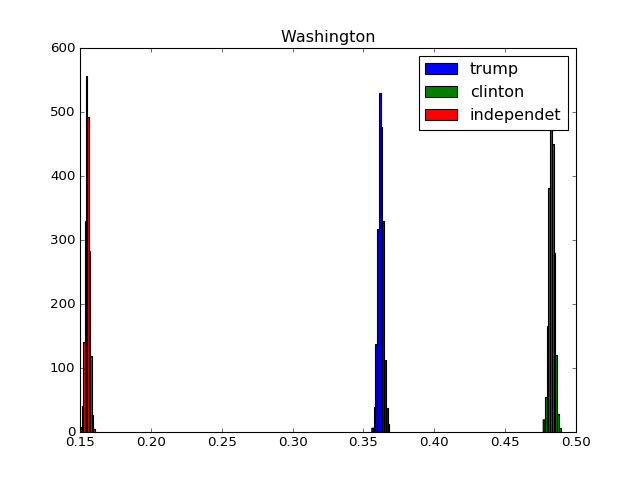

In [108]:
plt.figure()
s = 47
plt.hist(trace['theta'][:, s, 0], label='trump')
plt.hist(trace['theta'][:, s, 1], label='clinton')
plt.hist(trace['theta'][:, s, 2], label='independet')
plt.title(sorted(list(states))[s])
plt.legend()

In [109]:
votes_pred = trace['votes_pred']

In [110]:
votes_pred.shape

(2000, 51, 3)

In [111]:
winner = []
for election_sample in votes_pred:
    cnts = np.zeros(3)
    for s, tci in enumerate(election_sample):
        cnts[tci.argmax()] += nb_electors[s]
    if cnts.max() >= 270:
        winner.append(cnts.argmax())
    else:
        winner.append(-1)

In [114]:
set(winner)

{1}

<IPython.core.display.Javascript object>


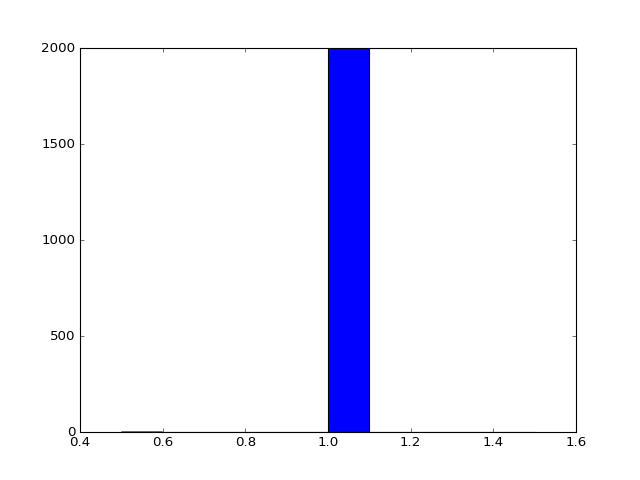

In [112]:
plt.figure()
plt.bar(winner);